In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# edit

### **Download Datasets from Kaggle**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
! kaggle datasets download -d 'ahmetfurkandemr/mask-datasets-v1'
! mkdir GoogleBangkit
! unzip mask-datasets-v1.zip -d GoogleBangkit

 98% 737M/754M [00:16<00:00, 40.9MB/s]
100% 754M/754M [00:16<00:00, 48.6MB/s]
Archive:  mask-datasets-v1.zip
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/1.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/10.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/100.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/101.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/102.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/103.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/104.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/105.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/106.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/107.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/108.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/109.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/11.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/110.PNG  
  inflating: GoogleBangkit/

### **Define the Data Directory**

In [4]:
base_dir = '../../bundle_archive/Mask_Datasets'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training Mask/No Mask pictures
train_Mask_dir = os.path.join(train_dir, 'Mask')
train_No_Mask_dir = os.path.join(train_dir, 'No_mask')

# Directory with our validation cat/dog pictures
validation_Mask_dir = os.path.join(validation_dir, 'Mask')
validation_No_Mask_dir = os.path.join(validation_dir, 'No_mask')

In [5]:
print('total training Mask images :', len(os.listdir(      train_Mask_dir ) ))
print('total training No Mask images :', len(os.listdir(      train_No_Mask_dir ) ))

print('total validation Mask images :', len(os.listdir( validation_Mask_dir ) ))
print('total validation No Mask images :', len(os.listdir( validation_No_Mask_dir ) ))

total training Mask images : 350
total training No Mask images : 400
total validation Mask images : 150
total validation No Mask images : 200


### **Image Visualization**

In [6]:
# Now, let's see what the filenames look like in the Mask and no mask train directories 
# (file naming conventions are the same in the validation directory)

train_Mask_fnames = os.listdir( train_Mask_dir )
train_No_Mask_fnames = os.listdir( train_No_Mask_dir )

print(train_Mask_fnames[:10])
print(train_No_Mask_fnames[:10])

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

['1.PNG', '10.PNG', '100.PNG', '101.PNG', '102.PNG', '103.PNG', '104.PNG', '105.PNG', '106.PNG', '107.PNG']
['15403.png', '15404.png', '15405.png', '15406.png', '15407.png', '15408.png', '15409.png', '15410.png', '15411.png', '15412.png']


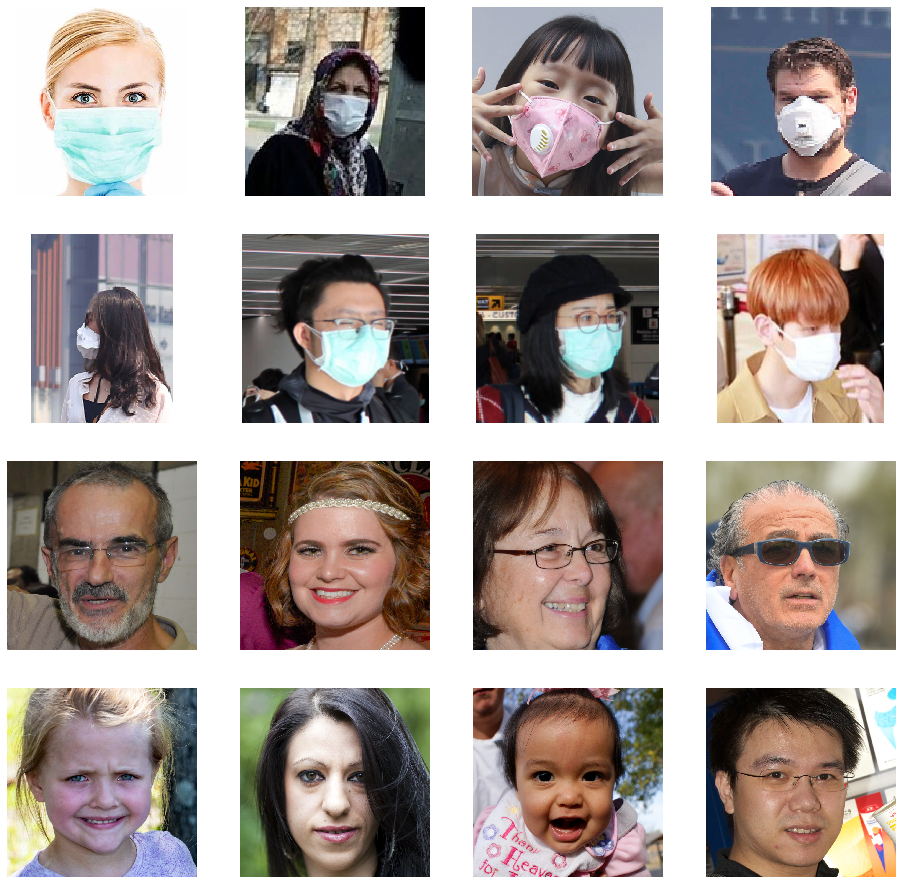

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Mask_pix = [os.path.join(train_Mask_dir, fname) 
                for fname in train_Mask_fnames[ pic_index-8:pic_index] 
               ]

next_No_Mask_pix = [os.path.join(train_No_Mask_dir, fname) 
                for fname in train_No_Mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Mask_pix+next_No_Mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### **3 LAYERS CNN MODEL**

In [ ]:
# DO NOT USE THIS MODEL FOR TRANSFER LEARNING

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Mask') and 1 for the other ('No_Mask')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [8]:
# USE THIS MODEL INSTEAD

IMAGE_SIZE = 224
dense = 2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False

9412608/9406464 [==============================] - 92s 10us/step


In [19]:
# ADD SOME LAYERS ABOVE BASE LAYER MODEL

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), 
  tf.keras.layers.Dense(1, activation='sigmoid')
])
print('Base model ready')

Base model ready


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### **Image Augmentation using ImageDataGenerator**

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# The ImageGenerator rescaling, rotate and do other operations.
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to IMAGE_SIZE
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      epochs=3,
      validation_data=validation_generator,
      verbose=1)

Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 38 steps, validate for 18 steps
Epoch 1/3
38/38 [==============================] - 166s 4s/step - loss: 0.0963 - accuracy: 0.9560 - val_loss: 0.0441 - val_accuracy: 0.9886
Epoch 2/3
38/38 [==============================] - 152s 4s/step - loss: 0.0698 - accuracy: 0.9760 - val_loss: 0.0748 - val_accuracy: 0.9686
Epoch 3/3
38/38 [==============================] - 150s 4s/step - loss: 0.0942 - accuracy: 0.9720 - val_loss: 0.0665 - val_accuracy: 0.9714


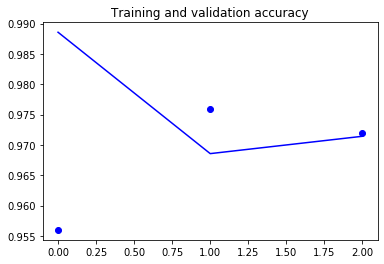

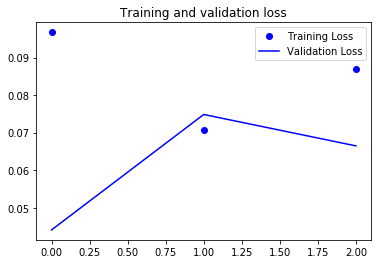

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Saved the model using tf.saved_model.save and then convert the saved model to a tf lite compatible format.

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
# Download the converted model and labels

from google.colab import files

files.download('model.tflite')